In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, TDR_axes, out_axes, make_FP_axs
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [3]:
task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti']

In [4]:
model_n = 0
task_list = ['fdgo', 'fdanti', 'delaygo', 'delayanti']
rule = task_list[0]
which_net = 'l2w0001'
fldr = 'all_tasks'
supp = []#'long_train'

if fldr == '4_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
h_all,trial_all,tasks_all = make_h_trial_rule(m,mode = 'test',noise_on = False)

figpath = os.path.join(p,'code','overleaf','multitask-nets','v1_figs','3d_incremental_animate')
if not os.path.exists(figpath):
    os.makedirs(figpath)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [5]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [6]:
def plot_N3D(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-'):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

        if isinstance(c_list, str) :
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
#         ax.scatter3D(X_trial[-1,0],X_trial[-1,1],X_trial[-1,2],'^',c = c, linewidth = linewidth, alpha = alpha)
        ax.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyle,c = c, linewidth = linewidth, alpha = alpha)
#         ax.scatter3D(X_trial[0,0],X_trial[0,1],X_trial[0,2],'.',c = c, linewidth = linewidth, alpha = alpha)
        
def plot_FP_jitter_3D(m,D_use,rule,t_num,fp_epoch,sorted_fps,fp_inds,qvals,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c = 'k'):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        trial = generate_trials(rule, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
        x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
#         for fp_ind in fp_inds:
#             for jit in range(n_jit):
#                 h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
#                 h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
#                 jitter = np.dot(h_t,D_use)
#                 ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = 'k',linewidth = .1)
                
        
        for jit in range(1):
            h0 = h_tf[T_inds[0],t_num,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,linewidth = 2)


In [7]:
h_all,trial_all,tasks_all = make_h_trial_rule(m,mode = 'test',noise_on = False)

fp_epoch = 'stim1'
ind = -1
T_inds = get_T_inds(trial_all[task_list[0]],fp_epoch)
B,N = np.shape(h_all[task_list[0]][T_inds[ind],:,:])
R = np.zeros((len(task_list)*B*len(T_inds),N))
Y = np.zeros((7,len(task_list)*B*len(T_inds)))

for rule_i in range(len(task_list)):
    rule = task_list[rule_i]
    T_inds = get_T_inds(trial_all[rule],fp_epoch)[-2:-1]
    r = np.reshape(h_all[rule][T_inds,:,:],(len(T_inds)*B,N))
    
    isanti = 'anti' in task_list[rule_i]
    ismemory = 'delay' in task_list[rule_i]
    y_anti = isanti*np.ones((np.shape(r)[0],1))
    y_memory = ismemory*np.ones((np.shape(r)[0],1))
    y_stim = np.repeat(np.min(trial_all[rule].stim_locs[:,[0,2]],axis=1),len(T_inds))
    y_out = np.repeat(trial_all[rule].y_loc[-1,:],len(T_inds))
    
    inds = range((B*len(T_inds))*rule_i,(B*len(T_inds))*(rule_i+1))
    
    R[inds,:] = r
    Y[0,inds] = np.expand_dims(isanti,axis = 0)
    Y[1,inds] = np.expand_dims(ismemory,axis = 0)
    Y[2,inds] = np.expand_dims(np.sin(y_stim),axis = 0)
    Y[3,inds] = np.expand_dims(np.cos(y_stim),axis = 0)
    Y[4,inds] = np.expand_dims(np.sin(y_out),axis = 0)
    Y[5,inds] = np.expand_dims(np.cos(y_out),axis = 0)
    Y[6,inds] = np.repeat(T_inds,B)
    
    Y_labels = ['ANTI v. Pro','MEMORY v. DELAY','STIM '+ r' $\cos{\theta}$','STIM '+ r' $\sin{\theta}$',
                'OUT '+ r' $\cos{\theta}$','OUT '+ r' $\sin{\theta}$','TIME']
    
lm = linear_model.LinearRegression()
model = lm.fit(Y.T,R)
Beta = model.coef_
Beta_qr,_ = LA.qr(Beta)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [8]:
from tools_lnd import comp_eig_decomp
from itertools import compress 

In [18]:
task_inds = [2,11]

In [68]:
all_task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

task_inds = [2,16]
task_list = [all_task_list[task_inds[0]],all_task_list[task_inds[1]]]

In [69]:
rule1 =  task_list[0]
rule2 =  task_list[1]

In [70]:
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, task_inds[1])
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

In [46]:
trial1 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [49]:
np.shape(trial1.x)

(135, 800, 25)

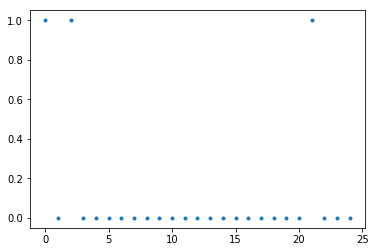

In [65]:
plt.plot(trial2.x[49,0,:],'.')

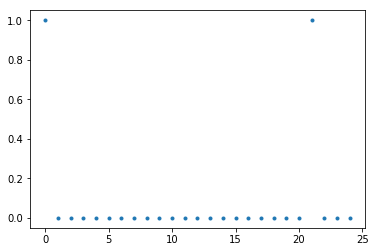

In [63]:
plt.plot(trial1.x[50,0,:],'.')

In [59]:
epoch = 'delay1'

In [71]:
t = 0
inputs_1 = trial1.x[int(50),t,:]
inputs_2 = trial2.x[int(50),t,:]
del_inputs = inputs_2 - inputs_1

In [73]:
task_list

['delaygo', 'dmsgo']

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


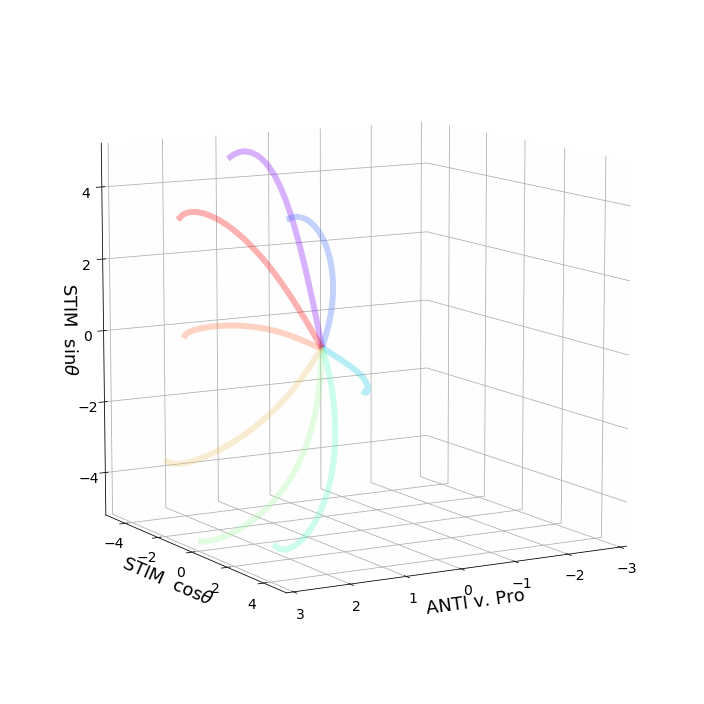

In [10]:
########## X TASK ###########
# from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

offset = 0
t_set = [0+offset, offset]
ind_stim_loc = t_set[0]

if ind_stim_loc == 0:
    trial_num = [0,0]
else:
    trial_num = [int(80*ind_stim_loc/360),int(80*ind_stim_loc/360)]
    
trial_set = range(0,80,10)
rule_set = ['delaygo', 'dmsgo']
epoch_set = ['delay1',]
step_file = 'interp_tasks'
linestyle = ['-',':']
n_interp = 20
    
trial_str = '_'.join(str(t) for t in t_set)
rule_str = '_'.join(str(r) for r in rule_set)

ei = 0
epoch = epoch_set[ei]

use_yinds = [0,2,3]
axes_label1 = Y_labels[use_yinds[0]]
axes_label2 = Y_labels[use_yinds[1]]
axes_label3 = Y_labels[use_yinds[2]]
D_use = Beta_qr[:,use_yinds]
D_use[:,2] = -D_use[:,2]

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['mediumblue','gold']
ax = fig.add_subplot(111, projection='3d')
w_color = .005
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(1):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
    plot_N3D(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ri],alpha = .3)

ax.set_xlabel(axes_label1,fontsize = 18)
ax.set_ylabel(axes_label2,fontsize = 18)
ax.set_zlabel(axes_label3,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim((-3, 3))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.view_init(10, 60)

tit = 'X TASK ' + epoch_set[ei]+' '+rule_set[0]+' vs.'+rule_set[1]
if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = 'single_trial_'+tit+'_'+step_file+'_'+str(t_set[0])
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))

plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

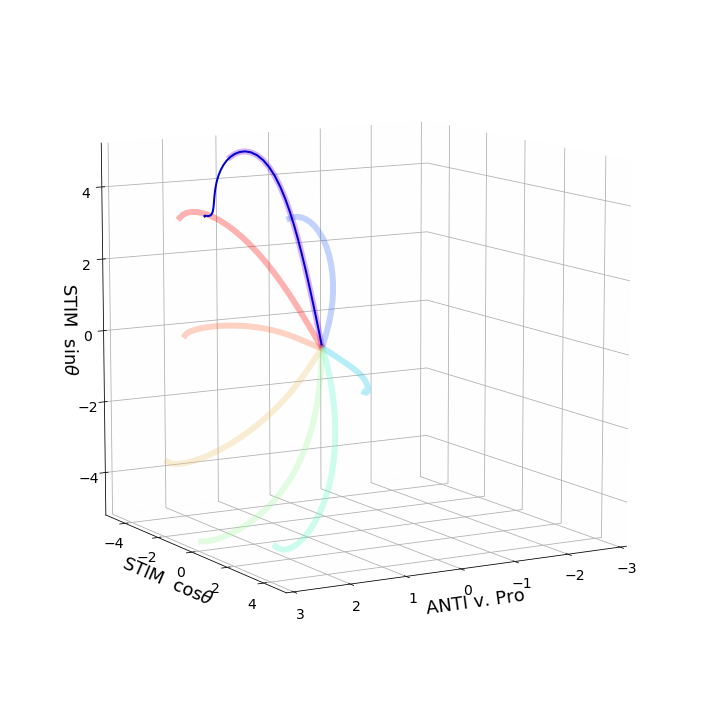

In [11]:
########## X TASK ###########
# from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(1):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
    plot_N3D(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ri],alpha = .3)
    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)

    plot_FP_jitter_3D(m,D_use,rule,trial_num[0],epoch,sorted_fps,range(len(sorted_fps)),qvals,
           rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 100, 
               n_jit = 0,c = cmap_discrete[ri])

ax.set_xlabel(axes_label1,fontsize = 18)
ax.set_ylabel(axes_label2,fontsize = 18)
ax.set_zlabel(axes_label3,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim((-3, 3))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.view_init(10, 60)

tit = 'X TASK ' + epoch_set[ei]+' '+rule_set[0]+' vs.'+rule_set[1]
if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = 'highlight_trial_'+tit+'_'+step_file+'_'+str(t_set[0])
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))

plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

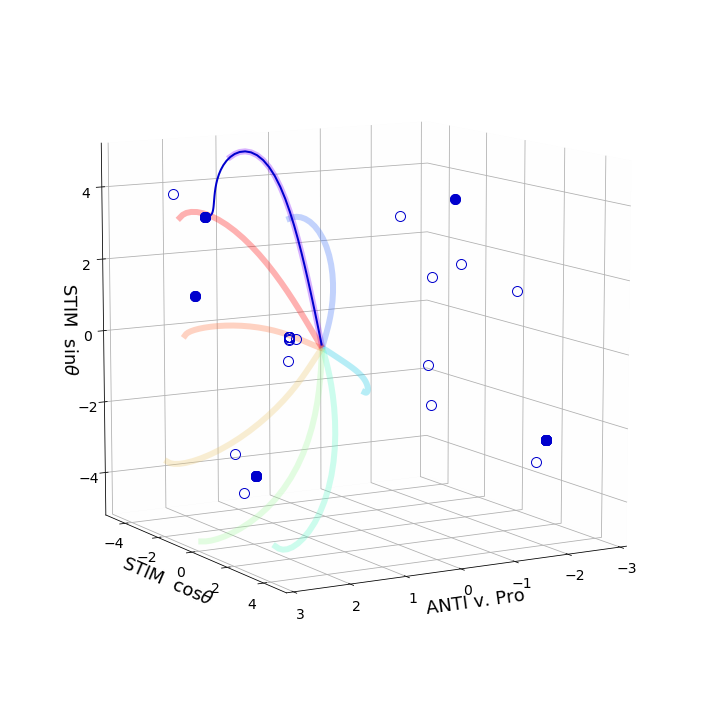

In [12]:
########## X TASK ###########
# from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(1):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
    plot_N3D(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ri],alpha = .3)
    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)

    plot_FP_jitter_3D(m,D_use,rule,trial_num[0],epoch,sorted_fps,range(len(sorted_fps)),qvals,
           rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 100, 
               n_jit = 0,c = cmap_discrete[ri])
    
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
    stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
    stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

    ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',c = cmap_discrete[ri],
             markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
    ax.plot3D(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],fp_project[stable_fps_arg,2],
               'o',c = cmap_discrete[ri],markersize = 10, alpha = 1,linewidth = 5)

ax.set_xlabel(axes_label1,fontsize = 18)
ax.set_ylabel(axes_label2,fontsize = 18)
ax.set_zlabel(axes_label3,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim((-3, 3))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.view_init(10, 60)

tit = 'X TASK ' + epoch_set[ei]+' '+rule_set[0]+' vs.'+rule_set[1]
if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = '1fp_'+tit+'_'+step_file+'_'+str(t_set[0])
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))

plt.show()

In [1]:
########## X TASK ###########
# from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(2):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
    plot_N3D(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ri],alpha = .3)
    
    if ri==0:
        f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
        fp_struct = np.load(f)
        sorted_fps = fp_struct['xstar']
        qvals = fp_struct['qstar']
        fp_project = np.dot(sorted_fps,D_use)

    
        plot_FP_jitter_3D(m,D_use,rule,trial_num[0],epoch,sorted_fps,range(len(sorted_fps)),qvals,
               rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 100, 
                   n_jit = 0,c = cmap_discrete[ri])
    
    
        eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
        stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
        stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

        ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',c = cmap_discrete[ri],
                 markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
        ax.plot3D(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],fp_project[stable_fps_arg,2],
                   'o',c = cmap_discrete[ri],markersize = 10, alpha = 1,linewidth = 5)

ax.set_xlabel(axes_label1,fontsize = 18)
ax.set_ylabel(axes_label2,fontsize = 18)
ax.set_zlabel(axes_label3,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim((-3, 3))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.view_init(10, 60)

tit = 'X TASK ' + epoch_set[ei]+' '+rule_set[0]+' vs.'+rule_set[1]
if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = '2tasks_'+tit+'_'+step_file+'_'+str(t_set[0])
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))

plt.show()

NameError: name 'plt' is not defined

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

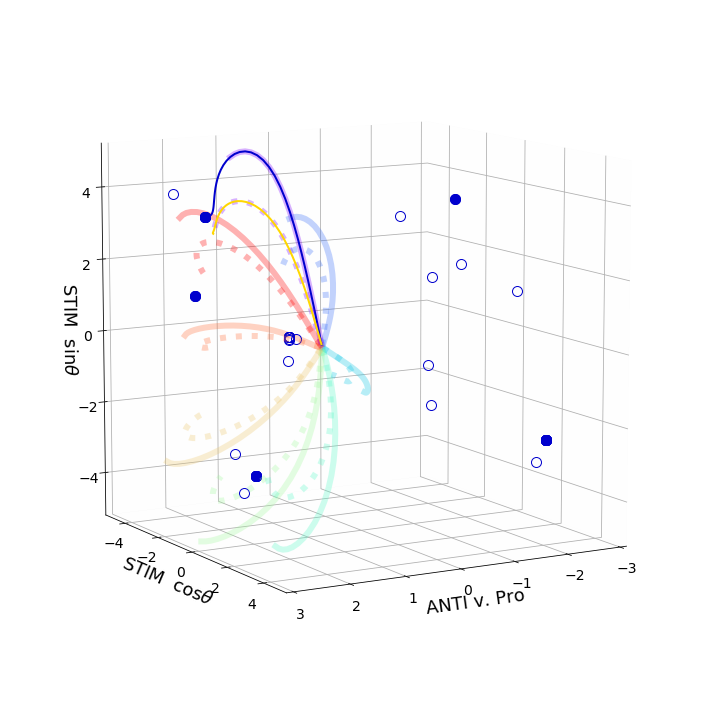

In [13]:
########## X TASK ###########
# from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(2):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
    plot_N3D(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ri],alpha = .3)
    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)

    plot_FP_jitter_3D(m,D_use,rule,trial_num[0],epoch,sorted_fps,range(len(sorted_fps)),qvals,
           rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 100, 
               n_jit = 0,c = cmap_discrete[ri])
    if ri==0:
        eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
        stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
        stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

        ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',c = cmap_discrete[ri],
                 markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
        ax.plot3D(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],fp_project[stable_fps_arg,2],
                   'o',c = cmap_discrete[ri],markersize = 10, alpha = 1,linewidth = 5)

ax.set_xlabel(axes_label1,fontsize = 18)
ax.set_ylabel(axes_label2,fontsize = 18)
ax.set_zlabel(axes_label3,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim((-3, 3))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.view_init(10, 60)

tit = 'X TASK ' + epoch_set[ei]+' '+rule_set[0]+' vs.'+rule_set[1]
if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = '2_highlight_'+tit+'_'+step_file+'_'+str(t_set[0])
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))

plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

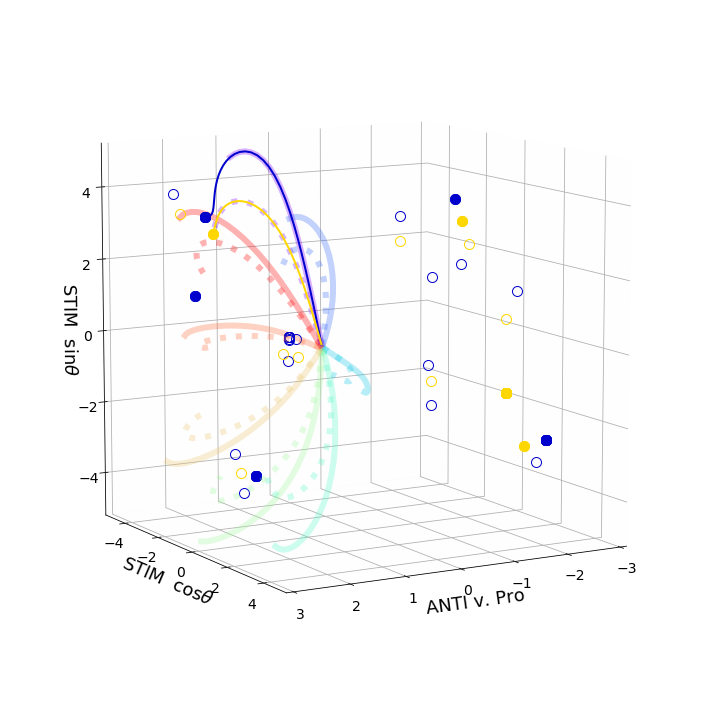

In [14]:
########## X TASK ###########
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(2):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
    plot_N3D(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ri],alpha = .3)
    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)

    plot_FP_jitter_3D(m,D_use,rule,trial_num[0],epoch,sorted_fps,range(len(sorted_fps)),qvals,
           rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 100, 
               n_jit = 0,c = cmap_discrete[ri])
    
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
    stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
    stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

    ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',c = cmap_discrete[ri],
             markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
    ax.plot3D(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],fp_project[stable_fps_arg,2],
               'o',c = cmap_discrete[ri],markersize = 10, alpha = 1,linewidth = 5)

ax.set_xlabel(axes_label1,fontsize = 18)
ax.set_ylabel(axes_label2,fontsize = 18)
ax.set_zlabel(axes_label3,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.set_xlim((-3, 3))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.view_init(10, 60)

tit = 'X TASK ' + epoch_set[ei]+' '+rule_set[0]+' vs.'+rule_set[1]
if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = 'all_fps_'+tit+'_'+step_file+'_'+str(t_set[0])
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))

plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

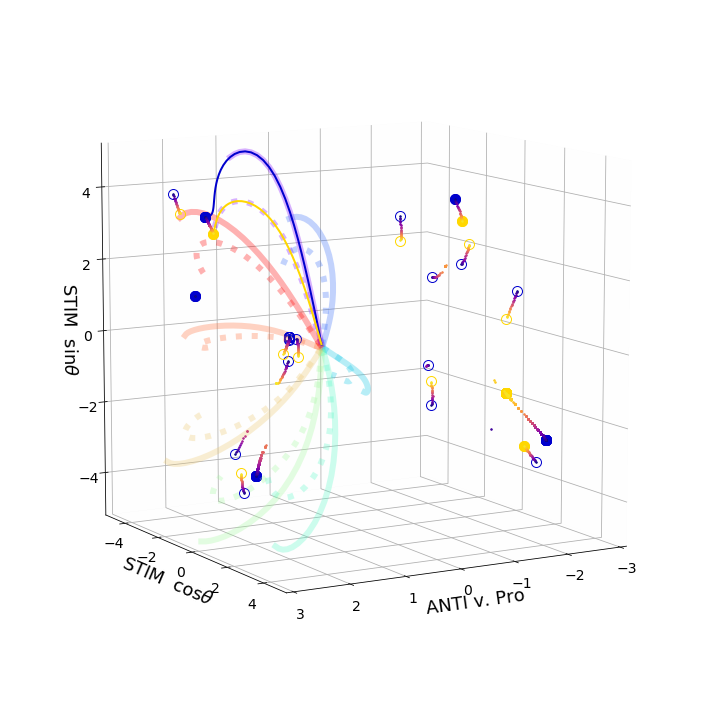

In [16]:
########## X TASK ###########
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(2):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
    plot_N3D(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ri],alpha = .3)
    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)

    plot_FP_jitter_3D(m,D_use,rule,trial_num[0],epoch,sorted_fps,range(len(sorted_fps)),qvals,
           rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 100, 
               n_jit = 0,c = cmap_discrete[ri])
    
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
    stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
    stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

    ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',c = cmap_discrete[ri],
             markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
    ax.plot3D(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],fp_project[stable_fps_arg,2],
               'o',c = cmap_discrete[ri],markersize = 10, alpha = 1,linewidth = 5)
    
for step_i in range(20):
    f = rule_set[0]+'_'+rule_set[1]+'_'+epoch_set[0]+'_'+str(t_set[0])+'_'+str(t_set[1])+'_step_'+str(step_i)#'_'+str(t_set[1])
    filename = os.path.join(m,step_file,rule_set[0]+'_'+rule_set[1],f+'.npz')
    fp_struct = np.load(filename)
    step_fps = fp_struct['xstar']

    fp_project = np.dot(step_fps,D_use)
    ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'.',markersize = 3,c = cmap_grad(step_i/n_interp))


ax.set_xlabel(axes_label1,fontsize = 18)
ax.set_ylabel(axes_label2,fontsize = 18)
ax.set_zlabel(axes_label3,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim((-3, 3))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.view_init(10, 60)

tit = 'X TASK ' + epoch_set[ei]+' '+rule_set[0]+' vs.'+rule_set[1]
if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = 'all_'+tit+'_'+step_file+'_'+str(t_set[0])
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))

plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

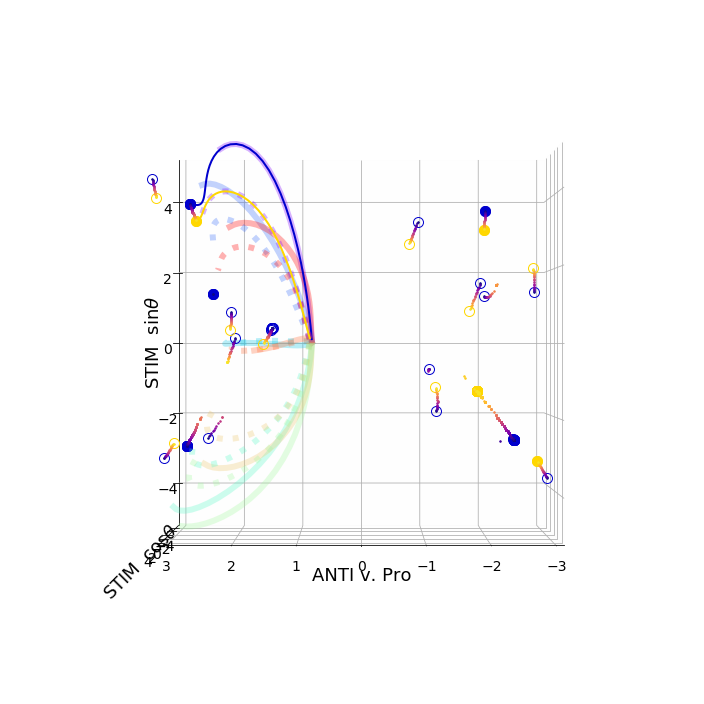

In [18]:
########## X TASK ###########
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(2):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
    plot_N3D(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ri],alpha = .3)
    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)

    plot_FP_jitter_3D(m,D_use,rule,trial_num[0],epoch,sorted_fps,range(len(sorted_fps)),qvals,
           rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 100, 
               n_jit = 0,c = cmap_discrete[ri])
    
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
    stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
    stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

    ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',c = cmap_discrete[ri],
             markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
    ax.plot3D(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],fp_project[stable_fps_arg,2],
               'o',c = cmap_discrete[ri],markersize = 10, alpha = 1,linewidth = 5)
    
for step_i in range(20):
    f = rule_set[0]+'_'+rule_set[1]+'_'+epoch_set[0]+'_'+str(t_set[0])+'_'+str(t_set[1])+'_step_'+str(step_i)#'_'+str(t_set[1])
    filename = os.path.join(m,step_file,rule_set[0]+'_'+rule_set[1],f+'.npz')
    fp_struct = np.load(filename)
    step_fps = fp_struct['xstar']

    fp_project = np.dot(step_fps,D_use)
    ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'.',markersize = 3,c = cmap_grad(step_i/n_interp))


ax.set_xlabel(axes_label1,fontsize = 18)
ax.set_ylabel(axes_label2,fontsize = 18)
ax.set_zlabel(axes_label3,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

tit = 'X TASK ' + epoch_set[ei]+' '+rule_set[0]+' vs.'+rule_set[1]
if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = 'all_reorient_'+tit+'_'+step_file+'_'+str(t_set[0])
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))

ax.set_xlim((-3, 3))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.view_init(0, 90)

plt.show()